In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from astropy.io import fits
from sklearn.tree import DecisionTreeRegressor
import glob
from astropy import units as u


In [2]:
#Glob away all the fits in a dir
fits_list =glob.glob("*.fits")
print(fits_list)

['spec-1678-53433-0001.fits', 'spec-1678-53433-0425.fits', 'spec-0548-51986-0020.fits', 'spec-0548-51986-0001.fits']


In [3]:
#Extra the fits tables from all the globbed fits
specdata_list=[]
for i in fits_list:
    with fits.open(i) as fit_file:
        specdata=fit_file[1].data
        header=fit_file[0].header
        specdata_list.append(specdata)

        

In [4]:
#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in specdata_list:
    print(i.shape)
    spec_shape_list.append(i.shape)

spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

(3822,)
(3846,)
(3828,)
(3769,)


In [5]:
#Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda
#to last lambda, as in some spectra the measurements start from different first to different last lambda
spectra_filtered_list=[]
for i in specdata_list:
    spec=i
    #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    spectra_filtered_list.append(filtered_data)
#And we have a np array containing individual spectras
spectra_filtered_list=np.array(spectra_filtered_list)
spectra_filtered_list.shape
spectra_filtered_list_array=np.array(spectra_filtered_list['sky'])


In [16]:

wavebins = spectra_filtered_list_array.shape[1]
num_spectra = spectra_filtered_list_array.shape[0]
master_sky_spectrum = np.zeros(wavebins)
pred=[]

# Running over each intensity value at a wavebin
for i in range(wavebins):
    # Intensities for the i wavelength bin for all fibres
    flux_at_wavebin = spectra_filtered_list_array[:, i]
    fibres=np.arange(num_spectra).reshape(-1,1)
    regressor = DecisionTreeRegressor(max_depth=3)  
    regressor.fit(fibres, flux_at_wavebin)  
    pred_values = regressor.predict(fibres) #Predict the each spectrum for all the fibres 
    pred.append(pred_values)
    master_sky_spectrum[i] = pred_values.mean() #Take the mean of all the predicted spectra

print("Generated Master Sky Spectrum:", master_sky_spectrum)



Generated Master Sky Spectrum: [ 8.88730168  8.13434225  7.63666338 ... 45.70083046 14.90502095
  5.31311858]


Text(0, 0.5, 'Flux')

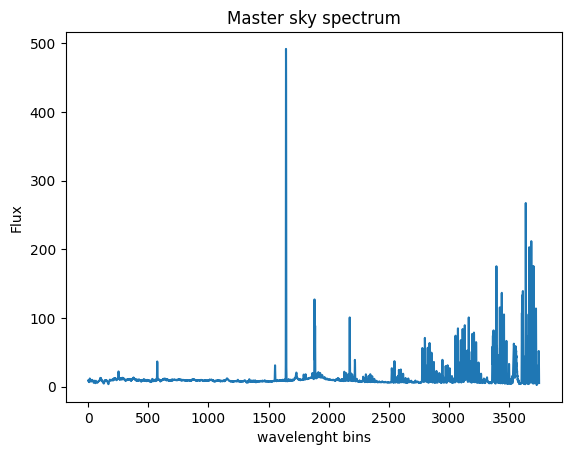

In [21]:
plt.plot(master_sky_spectrum)
plt.title('Master sky spectrum')
plt.xlabel('wavelenght bins')
plt.ylabel('Flux')

In [17]:
#scaling the master sky to the science spectra
ref_master= master_sky_spectrum[3600:3750]
ref_sky=spectra_filtered_list['sky'][:,3600:3750]

scaling=np.mean(ref_sky/ref_master)

master_scaled= master_sky_spectrum*scaling

Text(0, 0.5, 'Flux')

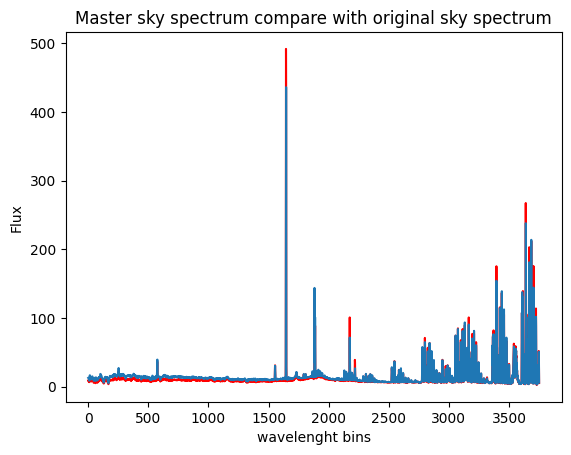

In [22]:
#scaling plots comparison
plt.plot(master_scaled, c='r')
plt.plot(spectra_filtered_list[1]['sky'])
plt.title('Master sky spectrum compare with original sky spectrum')
plt.xlabel('wavelenght bins')
plt.ylabel('Flux')


In [ ]:
#Under construction
import pandas as pd
import numpy as np

# Assuming 'spec1' is your original spectrum (as a NumPy array)

# Convert the spectrum to a pandas DataFrame to use the rolling function
spec1=spectra_filtered_list[1]['sky']
spectrum_df = pd.Series(spec1)

# Define the window size (number of data points in each window for median calculation)
window_size = 2  # You can adjust this based on the wavelength interval you want

# Calculate the rolling median using the specified window size
rolling_median = spectrum_df.rolling(window=window_size, center=True).median()

# Fill any NaN values that may appear at the edges where the window does not fully overlap
rolling_median_filled = rolling_median.fillna(method='bfill').fillna(method='ffill')

# Subtract the rolling median from the original spectrum for sky subtraction
final_spectrum = spec1 - rolling_median_filled.values

plt.plot(spec1)
plt.plot(rolling_median_filled, c='')




(3751,)

In [ ]:
#Under construction
#Median 

import numpy as np
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt


# Apply a median filter
median_filtered_spectrum = median_filter(spectra_filtered_list, size=3)

#plt.plot(spec1)
plt.figure(figsize=(10,3))
plt.plot(spec1)

plt.plot(median_filtered_spectrum)


In [ ]:


fig, ax =plt.subplots(nrows=9, figsize=(20,20))
ax[0].plot(master_sky[0])
ax[1].plot(rolling_median_filled)
ax[2].plot(median_filtered_spectrum)

ax[3].plot(master_sky[0]-spectra_filtered_list[0]['sky'])
ax[4].plot(rolling_median_filled-spectra_filtered_list[0]['sky'])
ax[5].plot(median_filtered_spectrum-spectra_filtered_list[0]['sky'])

ax[6].hist(master_sky[0]-spectra_filtered_list[0]['sky'], bins=200)
ax[7].hist(rolling_median_filled-spectra_filtered_list[0]['sky'], bins=200)
ax[8].hist(median_filtered_spectrum-spectra_filtered_list[0]['sky'], bins=200)

'plt.show()
